#### Crypto Trading Bot

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keyring
from yahoo_fin import stock_info as si

import pyotp

#import trend model functions
from trendmodel import *

# import robinhood functions
import robin_stocks.robinhood as r
from rh_account import *

In [2]:
# connect to robinhood account
login = r.login(keyring.get_password("robinhood","username"),keyring.get_password("robinhood","password"))

In [32]:
def get_historical_crypto(token, interval):
       
    # set span based on interval
    if interval=='15second':
        span = 'hour'
    if interval =='5minute':
        span = 'day'
    if interval == '10minute':
        span = 'day'
    if interval == 'hour':
        span = 'month'
        
    # get price data from robinhood
    price_df = pd.DataFrame(r.crypto.get_crypto_historicals(token, interval=interval, span=span, bounds='24_7', info=None))

    # rearrange dataframe columns since model expects yahoo price data and not robinhood

    # reorder columns
    columns = ["begins_at","high_price","low_price","open_price","close_price", "volume", "close_price"]
    price_df = price_df[columns]

    # rename columns
    price_df.columns = ["Date","High","Low","Open","Close","Volume","Adj Close"]

    # format date and re-index
    # price_df["Date"] = pd.to_datetime(price_df["Date"]).dt.strftime('%Y-%m-%d')
    price_df.set_index("Date", inplace=True)
    
    # convert data columns to floats
    columns = ["High","Low","Open","Close","Volume","Adj Close"]
    price_df[columns] = price_df[columns].astype(float)

    return price_df 

def process_tokens(tokens, interval):
    
    # load predictive model
    model_file = 'model.sav'
    model = joblib.load(model_file)
    
    # declare list to hold results
    results = []   
    
    # process tokens
    for i, token in enumerate(tokens):
        print('analyzing',token)
        price_df = get_historical_crypto(token, interval)
        
        # run model experiment
        model_signals = get_model_signals(token, price_df, model)
        model_return = backtest_signals(model_signals, 1)  
        
        # print(model_signals)

        # add signal to price df
        price_df['signal'] = model_signals['signal']

        # current signal
        if (model_signals['signal'].tail(1).iloc[0] == 0):
            action = 'sell'
        else:
            action = 'buy'

        # assemble result
        result = token, model_return, action

        # append results
        results.append(result)  

        # plot model signals
        plot_signals(model_signals, token + ' - ' + interval)

        # print tail of prices
        display(price_df.tail(5))

    # display output for buys
#     if(action == 'buy'):

#         # get current price
#         current_price = r.stocks.get_latest_price(token)[0]
#         stop_price = float(current_price) * .995

#         print("current price", current_price, "stop loss", stop_price)

#         print(result)

    return results

def plot_signals(signals, title):
    fig = plt.figure(figsize=(15,5))

    ax1 = fig.add_subplot(111,ylabel='Price')

    ax1.plot(signals['price'], color='black')
    ax1.plot(signals['sma10'], color='orange')
    ax1.plot(signals['ema20'], color='blue')
    ax1.plot(signals['ema30'], color='green')
    
    ax1.title.set_text(title)

    # plot buys
    ax1.plot(signals.loc[signals.positions == 1.0].index, \
             signals.sma10[signals.positions == 1.0], '^', markersize=20, color='g')

    # plot sells
    ax1.plot(signals.loc[signals.positions == -1.0].index, \
             signals.sma10[signals.positions == -1.0], 'v', markersize=20, color='r')
       
    plt.show()

In [ ]:
r.order_sell_crypto_limit_by_price()

analyzing ETH


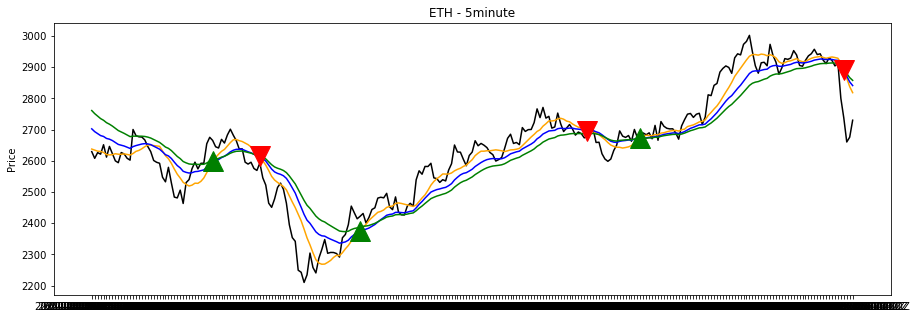

,High,Low,Open,Close,Volume,Adj Close,signal
Date,,,,,,,
2021-05-20T16:00:00Z,2927.595,2780.435,2912.805,2799.965,0.0,2799.965,1.0
2021-05-20T16:05:00Z,2805.455,2666.955,2788.870,2737.035,0.0,2737.035,0.0
2021-05-20T16:10:00Z,2780.490,2624.325,2738.530,2660.185,0.0,2660.185,0.0
2021-05-20T16:15:00Z,2728.575,2654.990,2660.185,2675.605,0.0,2675.605,0.0
2021-05-20T16:20:00Z,2742.520,2632.980,2675.605,2729.940,0.0,2729.940,0.0


analyzing ETH


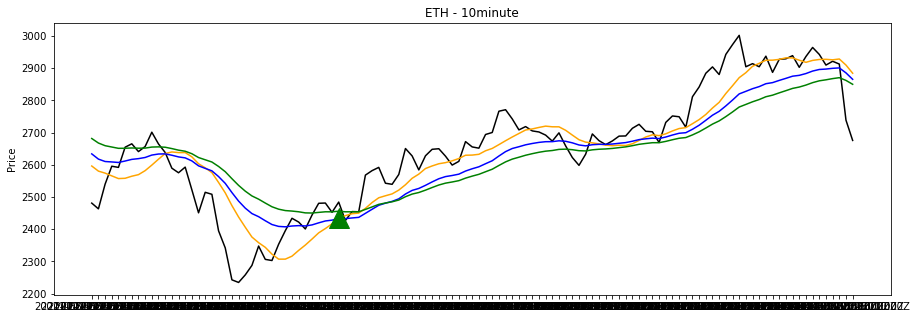

,High,Low,Open,Close,Volume,Adj Close,signal
Date,,,,,,,
2021-05-20T15:30:00Z,2956.500,2893.805,2931.040,2909.660,0.0,2909.660,1.0
2021-05-20T15:40:00Z,2959.150,2897.295,2909.660,2921.480,0.0,2921.480,1.0
2021-05-20T15:50:00Z,2939.960,2861.010,2921.480,2912.805,0.0,2912.805,1.0
2021-05-20T16:00:00Z,2927.595,2666.955,2912.805,2738.530,0.0,2738.530,1.0
2021-05-20T16:10:00Z,2780.490,2624.325,2738.530,2675.605,0.0,2675.605,1.0


analyzing ETH


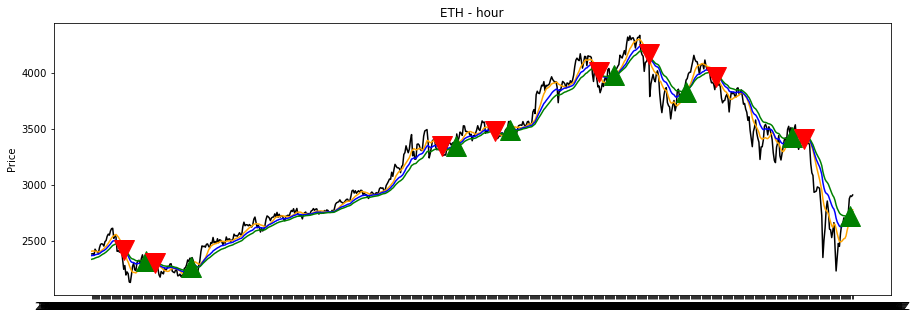

,High,Low,Open,Close,Volume,Adj Close,signal
Date,,,,,,,
2021-05-20T11:00:00Z,2774.605,2664.915,2725.660,2749.155,0.0,2749.155,0.0
2021-05-20T12:00:00Z,2916.405,2702.700,2748.155,2880.290,0.0,2880.290,0.0
2021-05-20T13:00:00Z,3008.150,2856.420,2880.290,2904.495,0.0,2904.495,1.0
2021-05-20T14:00:00Z,2983.800,2861.200,2904.495,2899.235,0.0,2899.235,1.0
2021-05-20T15:00:00Z,2977.485,2861.010,2914.535,2912.805,0.0,2912.805,1.0


In [35]:
tokens = ['ETH']

# interval = '15second'
# results = process_tokens(tokens,interval)

interval = '5minute'
results = process_tokens(tokens,interval)

interval = '10minute'
results = process_tokens(tokens,interval)

interval = 'hour'
results = process_tokens(tokens,interval)


analyzing BTC


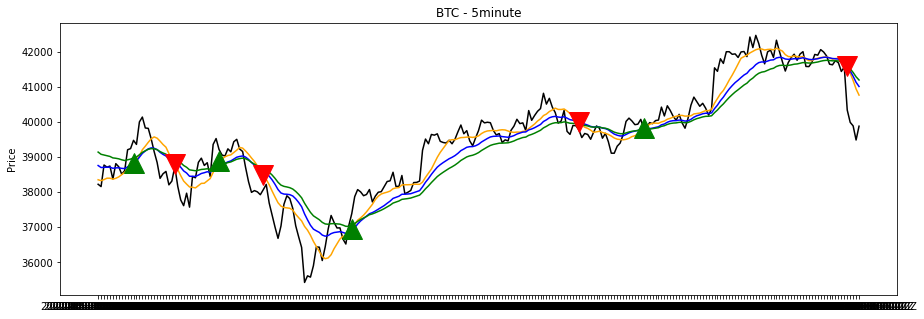

,High,Low,Open,Close,Volume,Adj Close,signal
Date,,,,,,,
2021-05-20T16:00:00Z,41714.385,40164.605000,41686.560,40346.995,0.0,40346.995,0.0
2021-05-20T16:05:00Z,40547.795,39384.390000,40281.085,39994.335,0.0,39994.335,0.0
2021-05-20T16:10:00Z,40553.465,39532.959614,39900.380,39893.215,0.0,39893.215,0.0
2021-05-20T16:15:00Z,40021.100,39344.725000,39451.915,39490.775,0.0,39490.775,0.0
2021-05-20T16:20:00Z,40143.080,39054.540000,39476.670,39884.825,0.0,39884.825,0.0


analyzing BTC


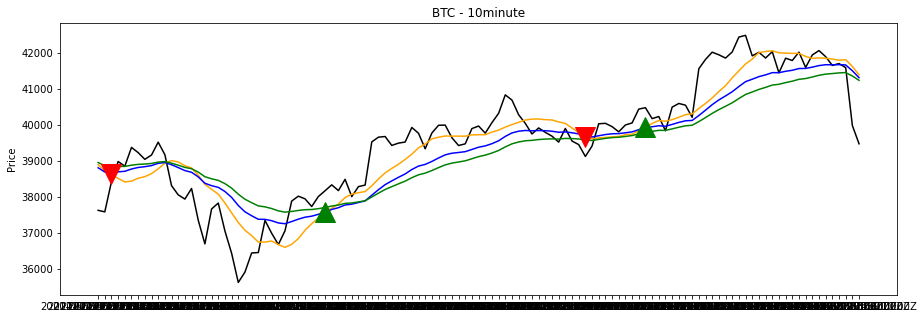

,High,Low,Open,Close,Volume,Adj Close,signal
Date,,,,,,,
2021-05-20T15:30:00Z,42003.565,41415.590,41885.080,41641.075,0.0,41641.075,1.0
2021-05-20T15:40:00Z,42080.570,41433.325,41539.200,41693.555,0.0,41693.555,1.0
2021-05-20T15:50:00Z,41826.065,40992.735,41693.555,41580.995,0.0,41580.995,1.0
2021-05-20T16:00:00Z,41714.385,39384.390,41686.560,39972.520,0.0,39972.520,1.0
2021-05-20T16:10:00Z,40553.465,39178.245,39900.380,39464.885,0.0,39464.885,1.0


analyzing BTC


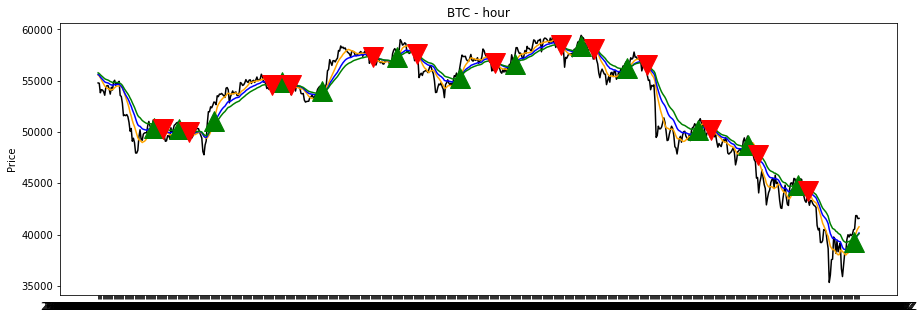

,High,Low,Open,Close,Volume,Adj Close,signal
Date,,,,,,,
2021-05-20T11:00:00Z,40794.240,39727.035,40467.275,40537.485,0.0,40537.485,1.0
2021-05-20T12:00:00Z,42097.110,40126.065,40593.460,41846.060,0.0,41846.060,1.0
2021-05-20T13:00:00Z,42602.305,41468.815,41847.310,41847.850,0.0,41847.850,1.0
2021-05-20T14:00:00Z,42707.985,41331.300,41903.485,41555.525,0.0,41555.525,1.0
2021-05-20T15:00:00Z,42271.190,40992.735,41585.520,41576.300,0.0,41576.300,1.0


In [36]:
tokens = ['BTC']

# interval = '15second'
# results = process_tokens(tokens,interval)

interval = '5minute'
results = process_tokens(tokens,interval)

interval = '10minute'
results = process_tokens(tokens,interval)

interval = 'hour'
results = process_tokens(tokens,interval)

In [30]:
tokens = ['DOGE']

# interval = '15second'
# results = process_tokens(tokens,interval)

interval = '5minute'
results = process_tokens(tokens,interval)

interval = '10minute'
results = process_tokens(tokens,interval)

interval = 'hour'
results = process_tokens(tokens,interval)

analyzing DOGE
                          high       low      open     price  volume  \
Date                                                                   
2021-05-19T17:30:00Z  0.400568  0.380828  0.395563  0.382575     0.0   
2021-05-19T17:35:00Z  0.394919  0.380854  0.382575  0.385622     0.0   
2021-05-19T17:40:00Z  0.390548  0.374944  0.385622  0.380043     0.0   
2021-05-19T17:45:00Z  0.387099  0.374914  0.378811  0.381194     0.0   
2021-05-19T17:50:00Z  0.389316  0.376146  0.381194  0.385774     0.0   
...                        ...       ...       ...       ...     ...   
2021-05-20T14:40:00Z  0.417841  0.413122  0.415437  0.414806     0.0   
2021-05-20T14:45:00Z  0.422724  0.415208  0.416529  0.418276     0.0   
2021-05-20T14:50:00Z  0.425870  0.414661  0.423424  0.418248     0.0   
2021-05-20T14:55:00Z  0.420316  0.412619  0.418248  0.414831     0.0   
2021-05-20T15:00:00Z  0.422159  0.412724  0.415607  0.419503     0.0   

                      adj close     sma10     em